### Init Parameters

In [1]:
%matplotlib inline

import os
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

root_folder = Path(os.getcwd())
dataset_dir = root_folder / "data/har-up-spiking-dataset-240"

batch_size = 4
nb_steps = 3000
max_length = 60.0
tau_mem = 100
tau_syn = 50

### Init Dataset

(128866,)


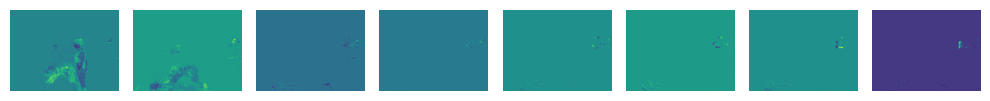

In [2]:
import tonic
from utils.SpikingDataset import SpikingDataset

dataset = SpikingDataset(
    root_dir=dataset_dir,
    time_duration=max_length,
    camera1_only=False,
)
train_dataset, dev_dataset, test_dataset = dataset.split_by_trials()

events, target = test_dataset[0]
print(events.shape)
tonic.utils.plot_event_grid(events, axis_array=[1,8])


### Init Dataloaders

In [3]:
from utils.SpikingDataLoader import SpikingDataLoader

train_loader = SpikingDataLoader(dataset=train_dataset,nb_steps=nb_steps,batch_size=batch_size,shuffle=False)
dev_loader = SpikingDataLoader(dataset=dev_dataset, nb_steps=nb_steps, batch_size=batch_size, shuffle=False)
test_loader = SpikingDataLoader(dataset=test_dataset, nb_steps=nb_steps, batch_size=batch_size, shuffle=False)

Initializing DataLoader of size 10
Initializing DataLoader of size 2
Initializing DataLoader of size 4


In [4]:
for x_local, y_local in test_loader:
    print(x_local.shape)

torch.Size([4, 3000, 240, 180])


### Init Old Model

In [5]:
from models.SpikingNN import SpikingNN

model = SpikingNN(
    layer_sizes=[240 * 180, 100, 50, 2],
    nb_steps=nb_steps,
    time_step=max_length / nb_steps,
    tau_mem=tau_mem * 1e-3,
    tau_syn=tau_syn * 1e-3,
)

### Init Leaky Model

In [5]:
from models.SNNTorchLeaky import SNNTorchLeaky

model = SNNTorchLeaky(
    num_inputs=dataset.nb_pixels,
    num_hidden=250,
    num_outputs=2,
    nb_steps=nb_steps,
    time_step=max_length / nb_steps,
    tau_mem=tau_mem * 1e-3,
)

LIF Parameter beta: 0.8187307530779818


### Init Synaptic Model

In [ ]:
from models.SNNTorchSyn import SNNTorchSyn

model = SNNTorchSyn(
    num_inputs=dataset.nb_pixels,
    num_hidden=250,
    num_outputs=2,
    nb_steps=nb_steps,
    time_step=max_length / nb_steps,
    tau_mem=tau_mem * 1e-3,
    tau_syn=tau_syn * 1e-3,
)

### Init Convolutional Model

In [6]:
from models.SNNTorchConv import SNNTorchConv

model = SNNTorchConv(
    num_inputs=dataset.nb_pixels,
    num_hidden=250,
    num_outputs=2,
    nb_steps=nb_steps,
    time_step=max_length / nb_steps,
    tau_mem=tau_mem * 1e-3,
)


LIF Parameter beta: 0.6703200460356393


### Train model

In [ ]:
from utils.Trainer import Trainer

trainer = Trainer(model=model)
trainer.train(
    train_loader,
    evaluate_dataloader=dev_loader,
    nb_epochs=20,
    stop_early=False,
    dataset_bias_ratio=10.0,
)

### Save model weights

In [4]:
model_name = "model"
model_save_file = root_folder / "models/saved"

# model.save(model_save_file / model_name)

### Load model weights

In [6]:
model_name = "B4_H100,50_LR25_W5_Best"
model_save_file = root_folder / "models/saved"

model.load(model_save_file / f"{model_name}.pth")

SpikingNN(
  (hidden_layers): ModuleList(
    (0-1): 2 x SpikingHiddenLayer()
  )
  (readout_layer): SpikingReadoutLayer()
)

### Test model

In [7]:
from utils.Trainer import Trainer

trainer = Trainer(model=model)
trainer.test(test_loader)

Test Set Metrics : {'loss': 0.0, 'accuracy': 0.9583333333333334, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}


{'loss': 0.0,
 'accuracy': 0.9583333333333334,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0}

### Evaluate model

In [7]:
import torch

with torch.inference_mode():
    for x_local, y_local in test_loader:

        x_local = x_local.to(model.device, model.dtype)
        y_local = y_local.to(model.device, model.dtype)

        mem_rec, spk_rec = model.forward(x_local.to_dense())
        break

mem_rec = mem_rec.cpu().detach().numpy()
spk_rec = spk_rec.cpu().detach()

### Visualize results

(4, 3000, 2)
torch.Size([4, 1, 3000, 5])


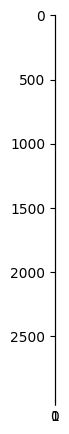

In [9]:
import numpy as np
from utils.snntorch_visualizers import plot_mem_spk
import matplotlib.pyplot as plt

print(mem_rec.shape)
print(spk_rec.shape)

arr = mem_rec
arr_ = np.squeeze(arr[0]) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)
plt.show()

# plot_mem_spk(mem_rec[0, :, 0], spk_rec[0, :, 0], thr_line=1, ylim_max=10.0, title="Leaky Neuron Model")

In [ ]:
plot_mem_spk(mem_rec[:, 0, 1], spk_rec[:, 0, 1], thr_line=1, ylim_max=2.0, title="Leaky Neuron Model")